In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Data ---
df_demographics = pd.read_excel('CustomerDemographics.xlsx')
df_behavior = pd.read_excel('CustomerBehaviorData.xlsx')
df_credit_consumption = pd.read_excel('CreditConsumptionData.xlsx')



In [13]:
# --- 2. Merge Data ---
df_merged = pd.merge(df_demographics, df_behavior, on='ID', how='inner')
df_full = pd.merge(df_merged, df_credit_consumption, on='ID', how='inner')

print("Initial data merge complete. Shape:", df_full.shape)
print("Columns:", df_full.columns.tolist())


Initial data merge complete. Shape: (20000, 49)
Columns: ['ID', 'account_type', 'gender', 'age', 'Income', 'Emp_Tenure_Years', 'Tenure_with_Bank', 'region_code', 'NetBanking_Flag', 'Avg_days_between_transaction', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may', 'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun', 'card_lim', 'personal_loan_active', 'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed', 'investment_1', 'investment_2', 'investment_3', 'investment_4', 'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr', 'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may', 'credit_count_may', 'debit_count_may', 'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun', 'loan_enq', 'emi_active', 'cc_cons']


In [15]:
# --- 3. Separate Data for Training and Prediction ---
df_train = df_full[df_full['cc_cons'].notna()].copy()
df_predict = df_full[df_full['cc_cons'].isna()].copy()

print(f"\nTraining data shape (non-missing cc_cons): {df_train.shape}")
print(f"Prediction data shape (missing cc_cons): {df_predict.shape}")

X_train_model = df_train.drop('cc_cons', axis=1)
y_train_model = df_train['cc_cons']
X_predict_missing = df_predict.drop('cc_cons', axis=1)


Training data shape (non-missing cc_cons): (15000, 49)
Prediction data shape (missing cc_cons): (5000, 49)


In [19]:
# --- 4. Enhanced Exploratory Data Analysis (EDA) ---
print("\n--- EDA: Training Data Overview ---")
print(df_train.head())
print("\n")


--- EDA: Training Data Overview ---
      ID account_type gender  age  Income  Emp_Tenure_Years  Tenure_with_Bank  \
0  17051      current      M   30  MEDIUM              26.4                 9   
1  11491      current      M   37     LOW              14.4                 7   
2   7433      current      M   33  MEDIUM               3.2                 1   
3  14606      current      M   63     LOW              10.2                 6   
4   8381       saving      M   33  MEDIUM              26.4                 6   

   region_code  NetBanking_Flag  Avg_days_between_transaction  ...  \
0            9              355                             0  ...   
1            7              485                             0  ...   
2            1              764                             0  ...   
3            6              863                             0  ...   
4            6              523                             0  ...   

   debit_count_may  max_credit_amount_may  debit_amount

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 14999
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            15000 non-null  int64  
 1   account_type                  15000 non-null  object 
 2   gender                        15000 non-null  object 
 3   age                           15000 non-null  int64  
 4   Income                        15000 non-null  object 
 5   Emp_Tenure_Years              15000 non-null  float64
 6   Tenure_with_Bank              15000 non-null  int64  
 7   region_code                   15000 non-null  int64  
 8   NetBanking_Flag               15000 non-null  int64  
 9   Avg_days_between_transaction  15000 non-null  int64  
 10  cc_cons_apr                   15000 non-null  float64
 11  dc_cons_apr                   15000 non-null  float64
 12  cc_cons_may                   15000 non-null  float64
 13  dc_con

In [23]:
print("\n--- EDA: Missing Values Summary ---")
missing_values = df_train.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print(missing_values)
print("\nPercentage of Missing Values:")
print((missing_values / len(df_train)) * 100)


--- EDA: Missing Values Summary ---
investment_3            2
loan_enq                2
dc_cons_may             1
cc_count_apr            1
personal_loan_closed    1
debit_count_apr         1
emi_active              1
dtype: int64

Percentage of Missing Values:
investment_3            0.013333
loan_enq                0.013333
dc_cons_may             0.006667
cc_count_apr            0.006667
personal_loan_closed    0.006667
debit_count_apr         0.006667
emi_active              0.006667
dtype: float64


In [25]:
print("\n--- EDA: Descriptive Statistics for Numerical Features ---")
print(df_train.select_dtypes(include=np.number).describe())


--- EDA: Descriptive Statistics for Numerical Features ---
                 ID           age  Emp_Tenure_Years  Tenure_with_Bank  \
count  15000.000000  15000.000000      15000.000000      15000.000000   
mean   10032.077067     47.790600         15.184007          5.510000   
std     5760.372343     30.632766         20.312648          2.865783   
min        1.000000     25.000000          0.500000          1.000000   
25%     5060.500000     33.000000          5.100000          3.000000   
50%    10054.000000     40.000000          9.900000          6.000000   
75%    15015.250000     53.000000         18.000000          8.000000   
max    19998.000000    223.000000        203.000000         10.000000   

        region_code  NetBanking_Flag  Avg_days_between_transaction  \
count  15000.000000     15000.000000                  15000.000000   
mean       5.510000       598.415467                      0.719533   
std        2.865783       220.062345                      0.449242   
mi

In [27]:
print("\n--- EDA: Value Counts for Categorical Features ---")
# List of categorical columns from the data dictionary (adjust if your actual data differs)
categorical_cols_for_eda = ['Account_type', 'Gender', 'Income', 'NetBanking_Flag', 'Loan_enq']
for col in categorical_cols_for_eda:
    if col in df_train.columns:
        print(f"\n--- {col} ---")
        print(df_train[col].value_counts())
        print(f"Missing in {col}: {df_train[col].isnull().sum()} \n")


--- EDA: Value Counts for Categorical Features ---

--- Income ---
Income
MEDIUM    9612
LOW       4188
HIGH      1200
Name: count, dtype: int64
Missing in Income: 0 


--- NetBanking_Flag ---
NetBanking_Flag
249    395
867    280
683    271
355    267
748    262
      ... 
618      1
608      1
857      1
484      1
436      1
Name: count, Length: 210, dtype: int64
Missing in NetBanking_Flag: 0 




--- EDA: Visualizations ---


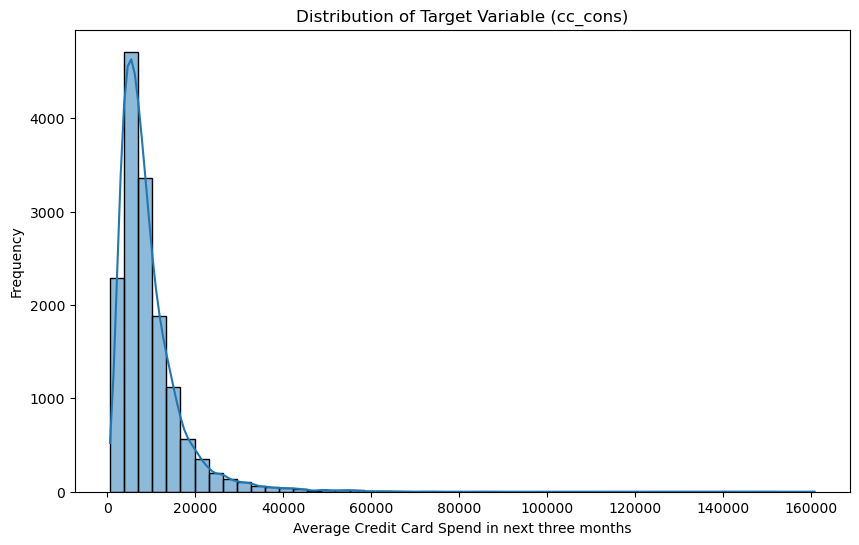

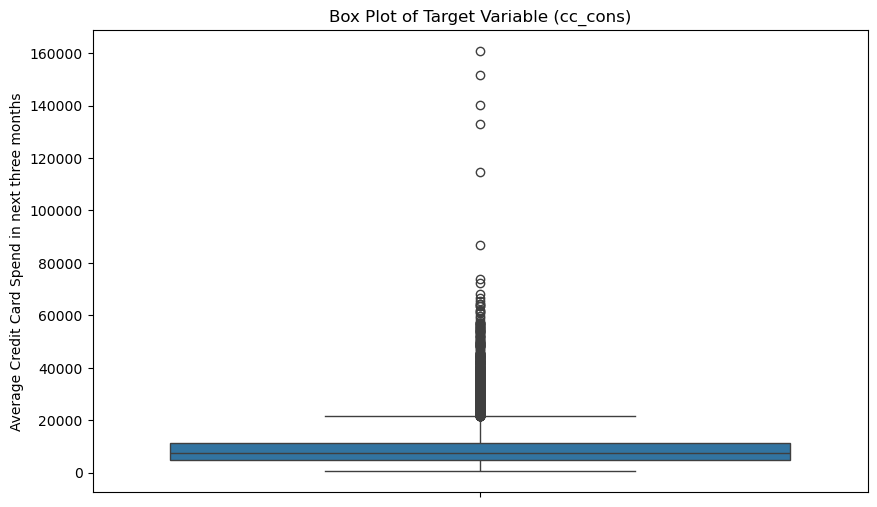

In [31]:
# --- EDA Visualizations ---

print("\n--- EDA: Visualizations ---")

# 1. Distribution of Target Variable (cc_cons)
plt.figure(figsize=(10, 6))
sns.histplot(y_train_model, kde=True, bins=50)
plt.title('Distribution of Target Variable (cc_cons)')
plt.xlabel('Average Credit Card Spend in next three months')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(y=y_train_model)
plt.title('Box Plot of Target Variable (cc_cons)')
plt.ylabel('Average Credit Card Spend in next three months')
plt.show()



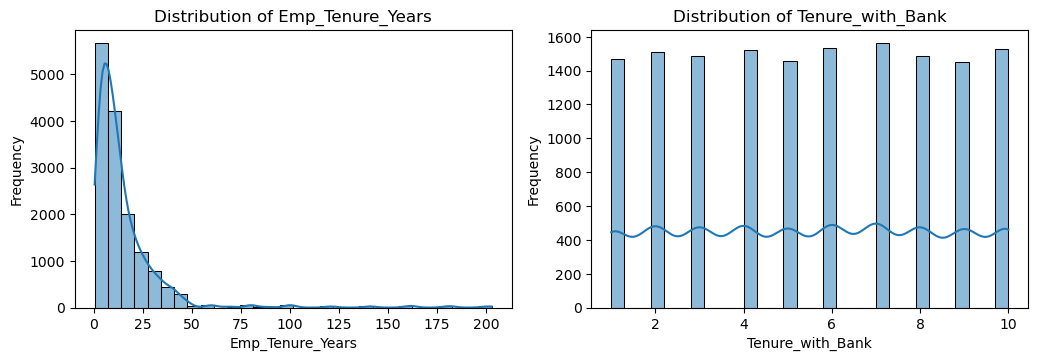

In [33]:
# 2. Distributions of Key Numerical Features (Examples)
# Select a few important numerical features for visualization.
# You'd typically visualize more or all based on your analysis.
numerical_features_to_plot = [
    'Age', 'Emp_Tenure_Years', 'Tenure_with_Bank',
    'CC_cons_jun', 'DC_cons_jun', 'Card_lim', 'Emi_active'
]

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features_to_plot):
    if col in df_train.columns:
        plt.subplot(3, 3, i + 1)
        sns.histplot(df_train[col].dropna(), kde=True, bins=30)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

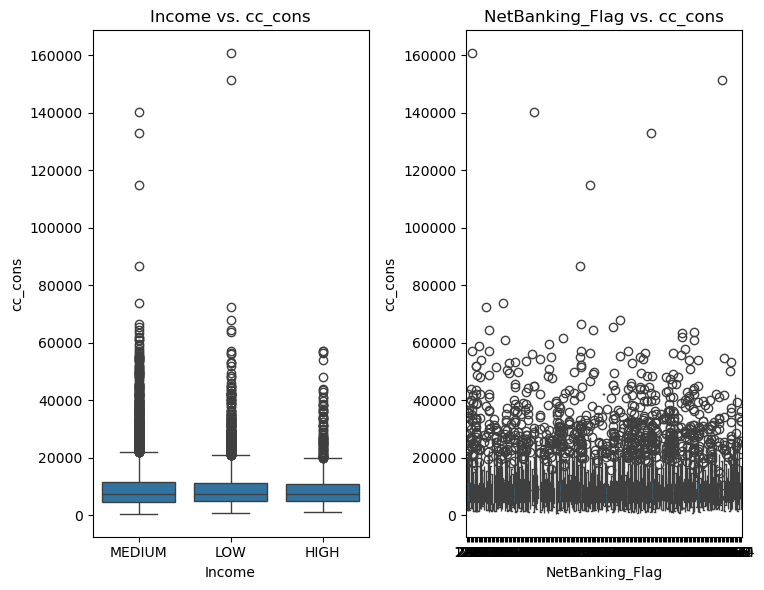

In [35]:
# 3. Relationships between Categorical Features and Target Variable
plt.figure(figsize=(18, 6))
for i, col in enumerate(categorical_cols_for_eda):
    if col in df_train.columns:
        plt.subplot(1, len(categorical_cols_for_eda), i + 1)
        sns.boxplot(x=col, y='cc_cons', data=df_train)
        plt.title(f'{col} vs. cc_cons')
        plt.xlabel(col)
        plt.ylabel('cc_cons')
plt.tight_layout()
plt.show()

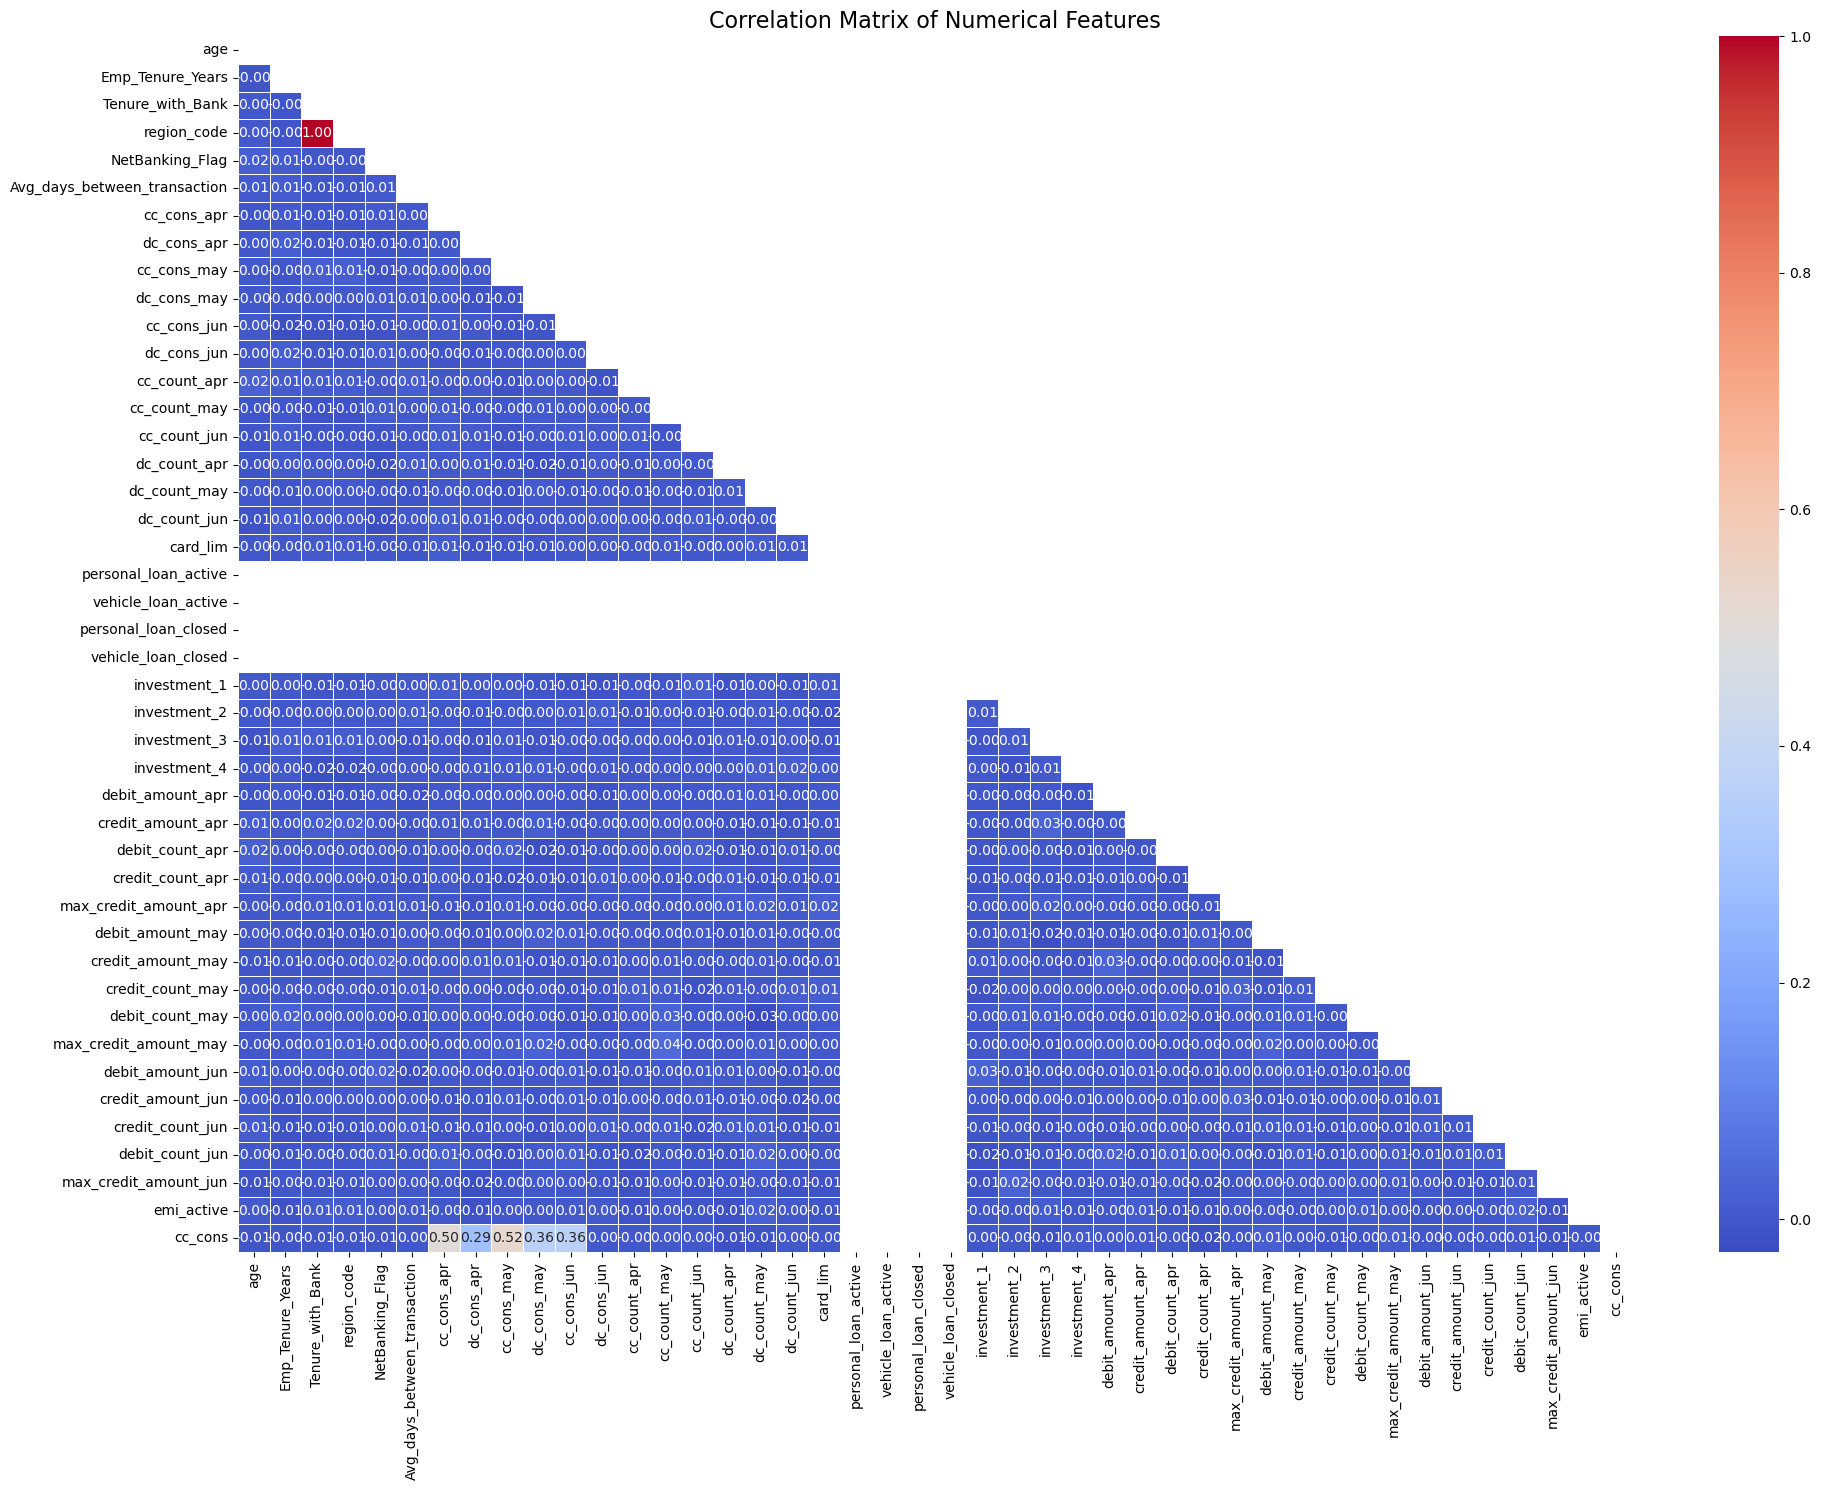

In [38]:
# 4. Correlation Matrix for Numerical Features
plt.figure(figsize=(20, 15))
numerical_data = df_train.select_dtypes(include=np.number).drop('ID', axis=1) # Exclude ID for correlation
# Calculate correlation matrix
correlation_matrix = numerical_data.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask=mask)
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [40]:
# --- 5. Preprocessing Pipelines (Same as before) ---
# Identify categorical and numerical features
categorical_features = X_train_model.select_dtypes(include=['object', 'category']).columns
numerical_features = X_train_model.select_dtypes(include=np.number).columns.drop('ID') # Exclude ID

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)



In [42]:
# --- 6. Define RMSPE Metric (Same as before) ---
def rmspe(y_true, y_pred):
    if not isinstance(y_true, np.ndarray):
        y_true = np.array(y_true)
    if not isinstance(y_pred, np.ndarray):
        y_pred = np.array(y_pred)

    epsilon = 1e-10
    percentage_error = np.abs((y_true - y_pred) / (y_true + epsilon)) * 100
    return np.sqrt(np.mean(percentage_error**2))

rmspe_scorer = make_scorer(rmspe, greater_is_better=False)



In [44]:
# --- 7. Build and Train the Model Pipeline (Same as before) ---
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

X_train, X_val, y_train, y_val = train_test_split(
    X_train_model, y_train_model, test_size=0.2, random_state=42
)

print(f"\nShape of X_train for model training: {X_train.shape}")
print(f"Shape of X_val for model validation: {X_val.shape}")

print("\nTraining the model...")
model_pipeline.fit(X_train, y_train)
print("Model training complete.")




Shape of X_train for model training: (12000, 48)
Shape of X_val for model validation: (3000, 48)

Training the model...
Model training complete.



--- Model Validation ---
Validation RMSPE: 26.8920%
Validation RMSE: 2609.2015


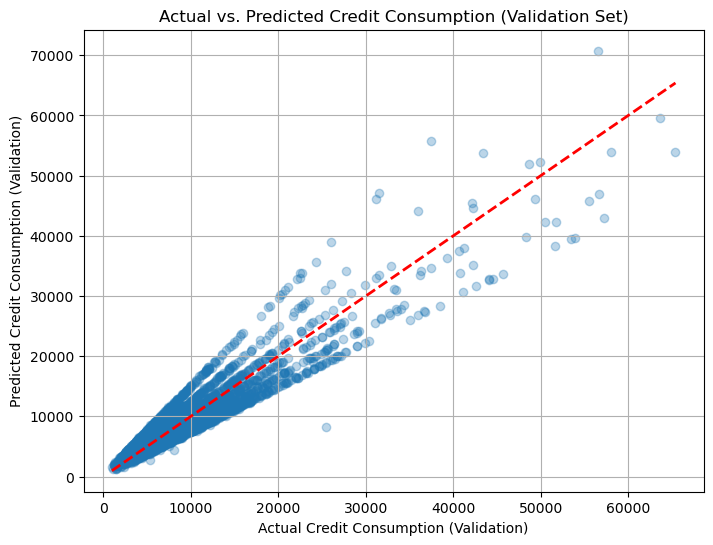

In [46]:
# --- 8. Model Validation (Same as before) ---
print("\n--- Model Validation ---")
y_val_pred = model_pipeline.predict(X_val)
y_val_pred[y_val_pred < 0] = 0

val_rmspe = rmspe(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"Validation RMSPE: {val_rmspe:.4f}%")
print(f"Validation RMSE: {val_rmse:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Credit Consumption (Validation)')
plt.ylabel('Predicted Credit Consumption (Validation)')
plt.title('Actual vs. Predicted Credit Consumption (Validation Set)')
plt.grid(True)
plt.show()



In [48]:
# --- 9. Predict for Customers with Missing 'cc_cons' (Same as before) ---
print("\nPredicting for customers with missing 'cc_cons'...")
predicted_cc_cons = model_pipeline.predict(X_predict_missing)
predicted_cc_cons[predicted_cc_cons < 0] = 0
df_predict['predicted_cc_cons'] = predicted_cc_cons

print("\nPredictions for missing values generated. Sample:")
print(df_predict[['ID', 'predicted_cc_cons']].head())




Predicting for customers with missing 'cc_cons'...

Predictions for missing values generated. Sample:
          ID  predicted_cc_cons
15000  17591        3111.081945
15001  13541        6941.881154
15002  13431        2607.297023
15003   8687        9048.149073
15004  14727        2636.434463


In [50]:
# --- 10. Save Predictions (Same as before) ---
output_df = df_predict[['ID', 'predicted_cc_cons']]
output_filename = 'predicted_credit_consumption.csv'
output_df.to_csv(output_filename, index=False)
print(f"\nPredictions saved to {output_filename}")

print("\n--- Script Finished ---")


Predictions saved to predicted_credit_consumption.csv

--- Script Finished ---
